# BGE-M3 vs Azure OpenAI 임베딩 모델 비교 실험

## 📋 실험 개요
이 노트북은 **BGE-M3**(Beijing Academy of Artificial Intelligence)와 **Azure OpenAI 임베딩 모델들**(`text-embedding-3-large`, `text-embedding-3-small`)의 성능을 비교 분석하는 실험을 수행합니다.

## 🎯 실험 목표
1. **다국어 지원 성능 비교**: 한국어와 영어 문서에 대한 검색 정확도 측정
2. **임베딩 품질 평가**: 코사인 유사도 기반 검색 성능 비교
3. **운영 효율성 분석**: 비용, 배포 복잡성, 확장성 등 실제 운영 관점에서의 비교
4. **하이브리드 검색**: Dense, Sparse, Multi-vector 검색 방식의 효과 검증

## 🔧 실험 구성
### 데이터셋
- **한국어**: 삼성전자 제품 스펙 및 설명 문서 (10개)
- **영어**: 기술 제품 설명서 (10개)
- **검색 쿼리**: 각 언어별 10개씩 총 20개

### 비교 모델
1. **BGE-M3** (via Ollama)
   - 다국어 지원 (100+ 언어)
   - Dense + Sparse + Multi-vector 검색 지원
   - 최대 8,192 토큰 문맥 처리

2. **Azure OpenAI text-embedding-3-large**
   - 3,072차원 고성능 임베딩
   - MTEB 벤치마크 64.6점
   - Matryoshka 학습 기반 동적 차원 조정

3. **Azure OpenAI text-embedding-3-small**
   - 1,536차원 경량 모델
   - 압도적 가성비 (1K 토큰당 $0.00002)
   - 이전 세대 대비 40% 향상된 다국어 성능

## 🧪 실험 방법론
1. **임베딩 생성**: 각 모델로 문서와 쿼리 임베딩 생성
2. **유사도 계산**: 코사인 유사도 기반 검색 성능 측정
3. **시각화**: 히트맵과 성능 차트를 통한 직관적 비교
4. **정량적 분석**: Top-1, Top-3 정확도 및 평균 유사도 점수 계산

## 📊 주요 발견사항 미리보기
- **BGE-M3**: 한글과 영어 모두에서 가장 안정적이고 높은 성능
- **Azure OpenAI Large**: 영어에서 뛰어난 성능, 한국어에서도 우수
- **Azure OpenAI Small**: 가성비 최고, 실용적 성능 수준
- **하이브리드 접근**: Dense + Sparse 조합으로 검색 성능 향상 가능 (Azure OpenAI모델은 AI Search에서 지원)

## 💡 실제 운영 고려사항
- **BGE-M3**: 높은 초기 투자 비용, 복잡한 인프라 관리 필요
- **Azure OpenAI**: 즉시 사용 가능, 확장성 우수, 예측 가능한 운영 비용
- **권장 전략**: 한국어 서비스는 `text-embedding-3-small` 기반 다중 인스턴스 운영


## 1. 필요한 라이브러리 설치 및 임포트

In [ ]:
# 필요한 패키지 설치
!pip install ollama numpy scikit-learn faiss-cpu matplotlib seaborn pandas requests

SyntaxError: invalid syntax (4144612786.py, line 2)

In [ ]:
import ollama
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Any
import json
import time
import warnings
warnings.filterwarnings('ignore')

# Azure OpenAI 관련 라이브러리
from openai import AzureOpenAI
import os
from dotenv import load_dotenv

# 환경변수 로드
load_dotenv('../.env')

# Azure OpenAI 클라이언트 초기화
azure_client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_KEY"),
    api_version="2024-02-01",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT")
)

print("필요한 라이브러리가 모두 임포트되었습니다.")
print(f"Azure OpenAI Endpoint: {os.getenv('AZURE_OPENAI_ENDPOINT')}")
print(f"Azure OpenAI Key 설정됨: {'✓' if os.getenv('AZURE_OPENAI_KEY') else '✗'}")

필요한 라이브러리가 모두 임포트되었습니다.
Azure OpenAI Endpoint: https://aistudioaiservices343274518006.openai.azure.com/
Azure OpenAI Key 설정됨: ✓


## 2. Ollama에서 BGE-M3 모델 다운로드

In [ ]:
# BGE-M3 모델 다운로드 (처음 실행 시에만 필요)
try:
    result = ollama.pull('bge-m3')
    print("BGE-M3 모델이 성공적으로 다운로드되었습니다.")
    print(result)
except Exception as e:
    print(f"모델 다운로드 중 오류 발생: {e}")
    print("터미널에서 'ollama pull bge-m3' 명령을 실행해 주세요.")

BGE-M3 모델이 성공적으로 다운로드되었습니다.
status='success' completed=None total=None digest=None


## 3. SOTA 수준 고정밀 데이터셋 준비

### 🎯 개선된 평가 방법론
기존의 일반적인 질문-응답 방식에서 **SOTA 임베딩 모델 평가에 적합한 고정밀 매칭**으로 업그레이드했습니다.

#### 📊 데이터셋 설계 원칙
1. **Perfect Semantic Alignment**: 각 쿼리는 해당 문서의 핵심 정보를 거의 동일하게 rephrase
2. **90+ Similarity Target**: SOTA 임베딩 모델들이 90점 이상의 유사도를 달성할 수 있도록 설계
3. **Technical Specification Focus**: 구체적인 제품 스펙과 기술적 세부사항 포함
4. **Multilingual Consistency**: 한글과 영어 데이터셋의 정확한 대응 관계 유지

#### 🔍 예상 성능 기준
- **Excellent (90-100)**: 완벽한 의미적 매칭
- **Good (80-89)**: 우수한 의미 이해
- **Fair (70-79)**: 기본적인 관련성 파악
- **Poor (<70)**: 의미적 연관성 부족

이러한 고정밀 데이터셋을 통해 각 임베딩 모델의 **진정한 의미 이해 능력**을 정확히 평가할 수 있습니다.

In [17]:
# 삼성전자 제품 스펙 및 설명 문서들 (고정밀 임베딩 평가용)
documents = [
    "갤럭시 S24 Ultra는 6.8인치 Dynamic AMOLED 2X 디스플레이를 탑재하고 있으며, 120Hz 적응형 주사율을 지원합니다. Snapdragon 8 Gen 3 for Galaxy 프로세서와 12GB RAM, 최대 1TB 스토리지를 제공합니다.",
    "삼성 Neo QLED 8K QN900C는 8K AI 업스케일링 기술과 Quantum Matrix Technology Pro를 적용한 75인치 프리미엄 TV입니다. Neural Quantum Processor 8K와 Object Tracking Sound Pro를 지원합니다.",
    "갤럭시 북4 Pro는 14인치 3K AMOLED 터치스크린과 Intel Core i7-1360P 프로세서를 탑재했습니다. 16GB LPDDR5 메모리와 512GB NVMe SSD, 63Wh 배터리를 제공합니다.",
    "삼성 비스포크 냉장고 RF85C9013AP는 871L 대용량 4도어 냉장고로 Twin Cooling Plus 기술을 적용했습니다. SmartThings 앱 연동과 Wi-Fi Direct 기능을 지원합니다.",
    "갤럭시 워치6 클래식은 47mm Super AMOLED 디스플레이와 Exynos W930 듀얼코어 프로세서를 탑재했습니다. 5ATM+IP68 방수등급과 최대 40시간 배터리 수명을 제공합니다.",
    "삼성 에어드레서 DF10A9500CG는 스팀 리프레시 기능과 제균 케어 시스템을 갖춘 의류관리기입니다. AI 행거 감지 기술과 SmartThings 앱을 통한 원격 제어가 가능합니다.",
    "갤럭시 탭 S9 Ultra는 14.6인치 Dynamic AMOLED 2X 디스플레이와 Snapdragon 8 Gen 2 for Galaxy를 탑재했습니다. S펜 포함, 최대 16GB RAM과 1TB 스토리지를 지원합니다.",
    "삼성 큐브 공기청정기 AX60T5580WFD는 360도 공기순환 시스템과 4단계 필터링을 제공합니다. PM 1.0까지 제거하며 60㎡ 공간에 적합한 CADR 467㎥/h 성능을 제공합니다.",
    "갤럭시 버즈2 Pro는 AKG 튜닝 사운드와 지능형 액티브 노이즈 캔슬링을 지원합니다. 360 오디오 기술과 최대 18시간 재생시간을 제공하며 IPX7 방수등급을 갖춥니다.",
    "삼성 무풍 에어컨 AR18CXHQASC는 Digital Inverter 기술로 에너지 효율 1등급을 달성했습니다. 무풍냉방과 AI 자동냉방, SmartThings 연동을 지원하며 18평형에 적합합니다."
]

# SOTA 수준 임베딩 평가를 위한 고정밀 매칭 쿼리들 (90+ 유사도 목표)
# 각 쿼리는 해당 문서의 핵심 내용을 거의 동일하게 rephrase한 형태
queries = [
    "Samsung Galaxy S24 Ultra 6.8인치 Dynamic AMOLED 2X 디스플레이, 120Hz 적응형 주사율, Snapdragon 8 Gen 3 for Galaxy 프로세서, 12GB RAM, 1TB 스토리지 스펙",  # Doc 0 매칭
    "삼성 Neo QLED 8K QN900C 75인치 프리미엄 TV, 8K AI 업스케일링, Quantum Matrix Technology Pro, Neural Quantum Processor 8K, Object Tracking Sound Pro 기능",  # Doc 1 매칭
    "Galaxy Book4 Pro 14인치 3K AMOLED 터치스크린, Intel Core i7-1360P 프로세서, 16GB LPDDR5 메모리, 512GB NVMe SSD, 63Wh 배터리 사양",  # Doc 2 매칭
    "Samsung Bespoke 냉장고 RF85C9013AP 871L 대용량 4도어, Twin Cooling Plus 기술, SmartThings 앱 연동, Wi-Fi Direct 지원 냉장고",  # Doc 3 매칭
    "갤럭시 워치6 클래식 47mm Super AMOLED 디스플레이, Exynos W930 듀얼코어 프로세서, 5ATM+IP68 방수등급, 40시간 배터리 수명 워치",  # Doc 4 매칭
    "Samsung AirDresser DF10A9500CG 스팀 리프레시 기능, 제균 케어 시스템, AI 행거 감지 기술, SmartThings 앱 원격 제어 의류관리기",  # Doc 5 매칭
    "Galaxy Tab S9 Ultra 14.6인치 Dynamic AMOLED 2X 디스플레이, Snapdragon 8 Gen 2 for Galaxy, S펜, 16GB RAM, 1TB 스토리지 태블릿",  # Doc 6 매칭
    "삼성 큐브 공기청정기 AX60T5580WFD 360도 공기순환 시스템, 4단계 필터링, PM 1.0 제거, 60㎡ 공간 적합, CADR 467㎥/h 성능",  # Doc 7 매칭
    "Galaxy Buds2 Pro AKG 튜닝 사운드, 지능형 액티브 노이즈 캔슬링, 360 오디오 기술, 18시간 재생시간, IPX7 방수등급 무선이어폰",  # Doc 8 매칭
    "Samsung 무풍 에어컨 AR18CXHQASC Digital Inverter 기술, 에너지 효율 1등급, 무풍냉방, AI 자동냉방, SmartThings 연동, 18평형 적합"  # Doc 9 매칭
]

print(f"문서 개수: {len(documents)}")
print(f"쿼리 개수: {len(queries)}")
print("\n🎯 SOTA 수준 임베딩 평가를 위한 고정밀 매칭 데이터셋")
print("목표: 90+ 유사도 점수 달성을 위한 문서-쿼리 완벽 매칭")
print("\n삼성 제품 문서-쿼리 매칭 샘플:")
for i in range(min(3, len(documents))):
    print(f"\n📄 문서 {i+1}: {documents[i]}")
    print(f"🔍 쿼리 {i+1}: {queries[i]}")
    print("=" * 80)

문서 개수: 10
쿼리 개수: 10

🎯 SOTA 수준 임베딩 평가를 위한 고정밀 매칭 데이터셋
목표: 90+ 유사도 점수 달성을 위한 문서-쿼리 완벽 매칭

삼성 제품 문서-쿼리 매칭 샘플:

📄 문서 1: 갤럭시 S24 Ultra는 6.8인치 Dynamic AMOLED 2X 디스플레이를 탑재하고 있으며, 120Hz 적응형 주사율을 지원합니다. Snapdragon 8 Gen 3 for Galaxy 프로세서와 12GB RAM, 최대 1TB 스토리지를 제공합니다.
🔍 쿼리 1: Samsung Galaxy S24 Ultra 6.8인치 Dynamic AMOLED 2X 디스플레이, 120Hz 적응형 주사율, Snapdragon 8 Gen 3 for Galaxy 프로세서, 12GB RAM, 1TB 스토리지 스펙

📄 문서 2: 삼성 Neo QLED 8K QN900C는 8K AI 업스케일링 기술과 Quantum Matrix Technology Pro를 적용한 75인치 프리미엄 TV입니다. Neural Quantum Processor 8K와 Object Tracking Sound Pro를 지원합니다.
🔍 쿼리 2: 삼성 Neo QLED 8K QN900C 75인치 프리미엄 TV, 8K AI 업스케일링, Quantum Matrix Technology Pro, Neural Quantum Processor 8K, Object Tracking Sound Pro 기능

📄 문서 3: 갤럭시 북4 Pro는 14인치 3K AMOLED 터치스크린과 Intel Core i7-1360P 프로세서를 탑재했습니다. 16GB LPDDR5 메모리와 512GB NVMe SSD, 63Wh 배터리를 제공합니다.
🔍 쿼리 3: Galaxy Book4 Pro 14인치 3K AMOLED 터치스크린, Intel Core i7-1360P 프로세서, 16GB LPDDR5 메모리, 512GB NVMe SSD, 63Wh 배터리 사양


## 4. 다중 모델 임베딩 생성 (BGE-M3 + Azure OpenAI)

In [18]:
class MultiModelEmbedder:
    """BGE-M3, Azure OpenAI text-embedding-3-large, text-embedding-3-small을 지원하는 통합 임베딩 클래스"""
    
    def __init__(self):
        self.models = {
            'bge-m3': {'type': 'ollama', 'dimension': 1024},
            'text-embedding-3-large': {'type': 'azure_openai', 'dimension': 3072},
            'text-embedding-3-small': {'type': 'azure_openai', 'dimension': 1536}
        }
        print("다중 모델 임베더 초기화 완료")
        print("지원 모델:", list(self.models.keys()))
        
    def get_embeddings(self, texts: List[str], model_name: str) -> np.ndarray:
        """지정된 모델로 텍스트들의 임베딩 생성"""
        if model_name not in self.models:
            raise ValueError(f"지원하지 않는 모델: {model_name}")
            
        model_info = self.models[model_name]
        embeddings = []
        
        print(f"\\n{model_name}으로 {len(texts)}개 텍스트의 임베딩 생성 중...")
        
        for i, text in enumerate(texts):
            print(f"  Processing {i+1}/{len(texts)}: {text[:50]}...")
            
            try:
                if model_info['type'] == 'ollama':
                    # BGE-M3 via Ollama
                    response = ollama.embeddings(model='bge-m3', prompt=text)
                    embedding = np.array(response['embedding'])
                    
                elif model_info['type'] == 'azure_openai':
                    # Azure OpenAI Embedding
                    response = azure_client.embeddings.create(
                        input=text,
                        model=model_name
                    )
                    embedding = np.array(response.data[0].embedding)
                    
                embeddings.append(embedding)
                
            except Exception as e:
                print(f"    오류 발생: {e}")
                # Fallback: 영벡터
                embeddings.append(np.zeros(model_info['dimension']))
                
            time.sleep(0.1)  # API 호출 간격
        
        embeddings_array = np.array(embeddings)
        print(f"  완료! Shape: {embeddings_array.shape}")
        return embeddings_array
    
    def get_all_model_embeddings(self, texts: List[str]) -> Dict[str, np.ndarray]:
        """모든 모델에 대해 임베딩 생성"""
        all_embeddings = {}
        
        for model_name in self.models.keys():
            print(f"\\n{'='*50}")
            print(f"모델: {model_name}")
            print(f"{'='*50}")
            
            embeddings = self.get_embeddings(texts, model_name)
            all_embeddings[model_name] = embeddings
            
        return all_embeddings

# 다중 모델 임베더 초기화
multi_embedder = MultiModelEmbedder()

# 문서들의 모든 모델 임베딩 생성
print("\\n🔄 문서 임베딩 생성 시작...")
doc_all_embeddings = multi_embedder.get_all_model_embeddings(documents)

print("\\n📊 문서 임베딩 결과:")
for model_name, embeddings in doc_all_embeddings.items():
    print(f"  {model_name}: {embeddings.shape}")

# 쿼리들의 모든 모델 임베딩 생성  
print("\\n🔄 쿼리 임베딩 생성 시작...")
query_all_embeddings = multi_embedder.get_all_model_embeddings(queries)

print("\\n📊 쿼리 임베딩 결과:")
for model_name, embeddings in query_all_embeddings.items():
    print(f"  {model_name}: {embeddings.shape}")
    
print("\\n✅ 모든 모델의 임베딩 생성 완료!")

다중 모델 임베더 초기화 완료
지원 모델: ['bge-m3', 'text-embedding-3-large', 'text-embedding-3-small']
\n🔄 문서 임베딩 생성 시작...
\n==================================================
모델: bge-m3
\nbge-m3으로 10개 텍스트의 임베딩 생성 중...
  Processing 1/10: 갤럭시 S24 Ultra는 6.8인치 Dynamic AMOLED 2X 디스플레이를 탑재하고...
  Processing 2/10: 삼성 Neo QLED 8K QN900C는 8K AI 업스케일링 기술과 Quantum Mat...
  Processing 3/10: 갤럭시 북4 Pro는 14인치 3K AMOLED 터치스크린과 Intel Core i7-13...
  Processing 2/10: 삼성 Neo QLED 8K QN900C는 8K AI 업스케일링 기술과 Quantum Mat...
  Processing 3/10: 갤럭시 북4 Pro는 14인치 3K AMOLED 터치스크린과 Intel Core i7-13...
  Processing 4/10: 삼성 비스포크 냉장고 RF85C9013AP는 871L 대용량 4도어 냉장고로 Twin Co...
  Processing 5/10: 갤럭시 워치6 클래식은 47mm Super AMOLED 디스플레이와 Exynos W930 ...
  Processing 4/10: 삼성 비스포크 냉장고 RF85C9013AP는 871L 대용량 4도어 냉장고로 Twin Co...
  Processing 5/10: 갤럭시 워치6 클래식은 47mm Super AMOLED 디스플레이와 Exynos W930 ...
  Processing 6/10: 삼성 에어드레서 DF10A9500CG는 스팀 리프레시 기능과 제균 케어 시스템을 갖춘 의류...
  Processing 7/10: 갤럭시 탭 S9 Ultra는 14.6인치 Dynamic AMOLED 2X 디스플레이와 

## 5. 다중 모델 검색 시스템 구현

In [19]:
class MultiModelSearcher:
    """다중 모델 검색 시스템: BGE-M3, text-embedding-3-large, text-embedding-3-small"""
    
    def __init__(self, doc_embeddings: Dict[str, np.ndarray], documents: List[str]):
        self.doc_embeddings = doc_embeddings
        self.documents = documents
        self.model_names = list(doc_embeddings.keys())
        
        # 각 모델별 FAISS 인덱스 생성
        self.faiss_indices = {}
        
        for model_name, embeddings in doc_embeddings.items():
            dimension = embeddings.shape[1]
            index = faiss.IndexFlatIP(dimension)  # Inner Product
            
            # L2 정규화 적용
            normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
            index.add(normalized_embeddings.astype('float32'))
            
            self.faiss_indices[model_name] = index
            print(f"{model_name}: FAISS 인덱스 생성 완료 (차원: {dimension})")
        
        print(f"\\n다중 모델 검색 시스템 초기화 완료")
        print(f"지원 모델: {self.model_names}")
        print(f"문서 수: {len(documents)}")
    
    def search_single_model(self, query_embedding: np.ndarray, model_name: str, k: int = 5) -> List[Tuple[int, float]]:
        """단일 모델로 검색 수행"""
        if model_name not in self.faiss_indices:
            raise ValueError(f"지원하지 않는 모델: {model_name}")
        
        # 쿼리 정규화
        query_normalized = query_embedding / np.linalg.norm(query_embedding)
        query_normalized = query_normalized.reshape(1, -1).astype('float32')
        
        # 검색 수행
        scores, indices = self.faiss_indices[model_name].search(query_normalized, k)
        return list(zip(indices[0], scores[0]))
    
    def search_all_models(self, query_embeddings: Dict[str, np.ndarray], query_idx: int, k: int = 5) -> Dict[str, List[Tuple[int, float, str]]]:
        """모든 모델로 검색 수행"""
        results = {}
        
        for model_name in self.model_names:
            query_emb = query_embeddings[model_name][query_idx]
            search_results = self.search_single_model(query_emb, model_name, k)
            
            # 결과에 문서 텍스트 추가
            results[model_name] = [
                (idx, score, self.documents[idx]) 
                for idx, score in search_results
            ]
            
        return results

# 다중 모델 검색 시스템 초기화
multi_searcher = MultiModelSearcher(doc_all_embeddings, documents)

bge-m3: FAISS 인덱스 생성 완료 (차원: 1024)
text-embedding-3-large: FAISS 인덱스 생성 완료 (차원: 3072)
text-embedding-3-small: FAISS 인덱스 생성 완료 (차원: 1536)
\n다중 모델 검색 시스템 초기화 완료
지원 모델: ['bge-m3', 'text-embedding-3-large', 'text-embedding-3-small']
문서 수: 10


## 6. 모델별 검색 성능 비교 및 시각화

🚀 다중 모델 검색 실험 시작...
🔍 다중 모델 검색 성능 비교 (BGE-M3 vs Azure OpenAI Embeddings)

🔍 쿼리 1: 'Samsung Galaxy S24 Ultra 6.8인치 Dynamic AMOLED 2X 디스플레이, 120Hz 적응형 주사율, Snapdragon 8 Gen 3 for Galaxy 프로세서, 12GB RAM, 1TB 스토리지 스펙'
--------------------------------------------------------------------------------

📊 bge-m3:
  1. (점수: 0.9635) 갤럭시 S24 Ultra는 6.8인치 Dynamic AMOLED 2X 디스플레이를 탑재하고 있으며, 120Hz 적응형 주사율을 지원합니다. Snapdragon 8 Gen 3 for...
  2. (점수: 0.7660) 갤럭시 탭 S9 Ultra는 14.6인치 Dynamic AMOLED 2X 디스플레이와 Snapdragon 8 Gen 2 for Galaxy를 탑재했습니다. S펜 포함, 최대 16G...
  3. (점수: 0.5389) 갤럭시 북4 Pro는 14인치 3K AMOLED 터치스크린과 Intel Core i7-1360P 프로세서를 탑재했습니다. 16GB LPDDR5 메모리와 512GB NVMe SSD,...

📊 text-embedding-3-large:
  1. (점수: 0.8594) 갤럭시 S24 Ultra는 6.8인치 Dynamic AMOLED 2X 디스플레이를 탑재하고 있으며, 120Hz 적응형 주사율을 지원합니다. Snapdragon 8 Gen 3 for...
  2. (점수: 0.6673) 갤럭시 탭 S9 Ultra는 14.6인치 Dynamic AMOLED 2X 디스플레이와 Snapdragon 8 Gen 2 for Galaxy를 탑재했습니다. S펜 포함, 최대 16G...
  3. (점수: 0.5815) 갤럭시 북4 Pro는 14인치 3K AMOLED 터치스크린과 Intel 

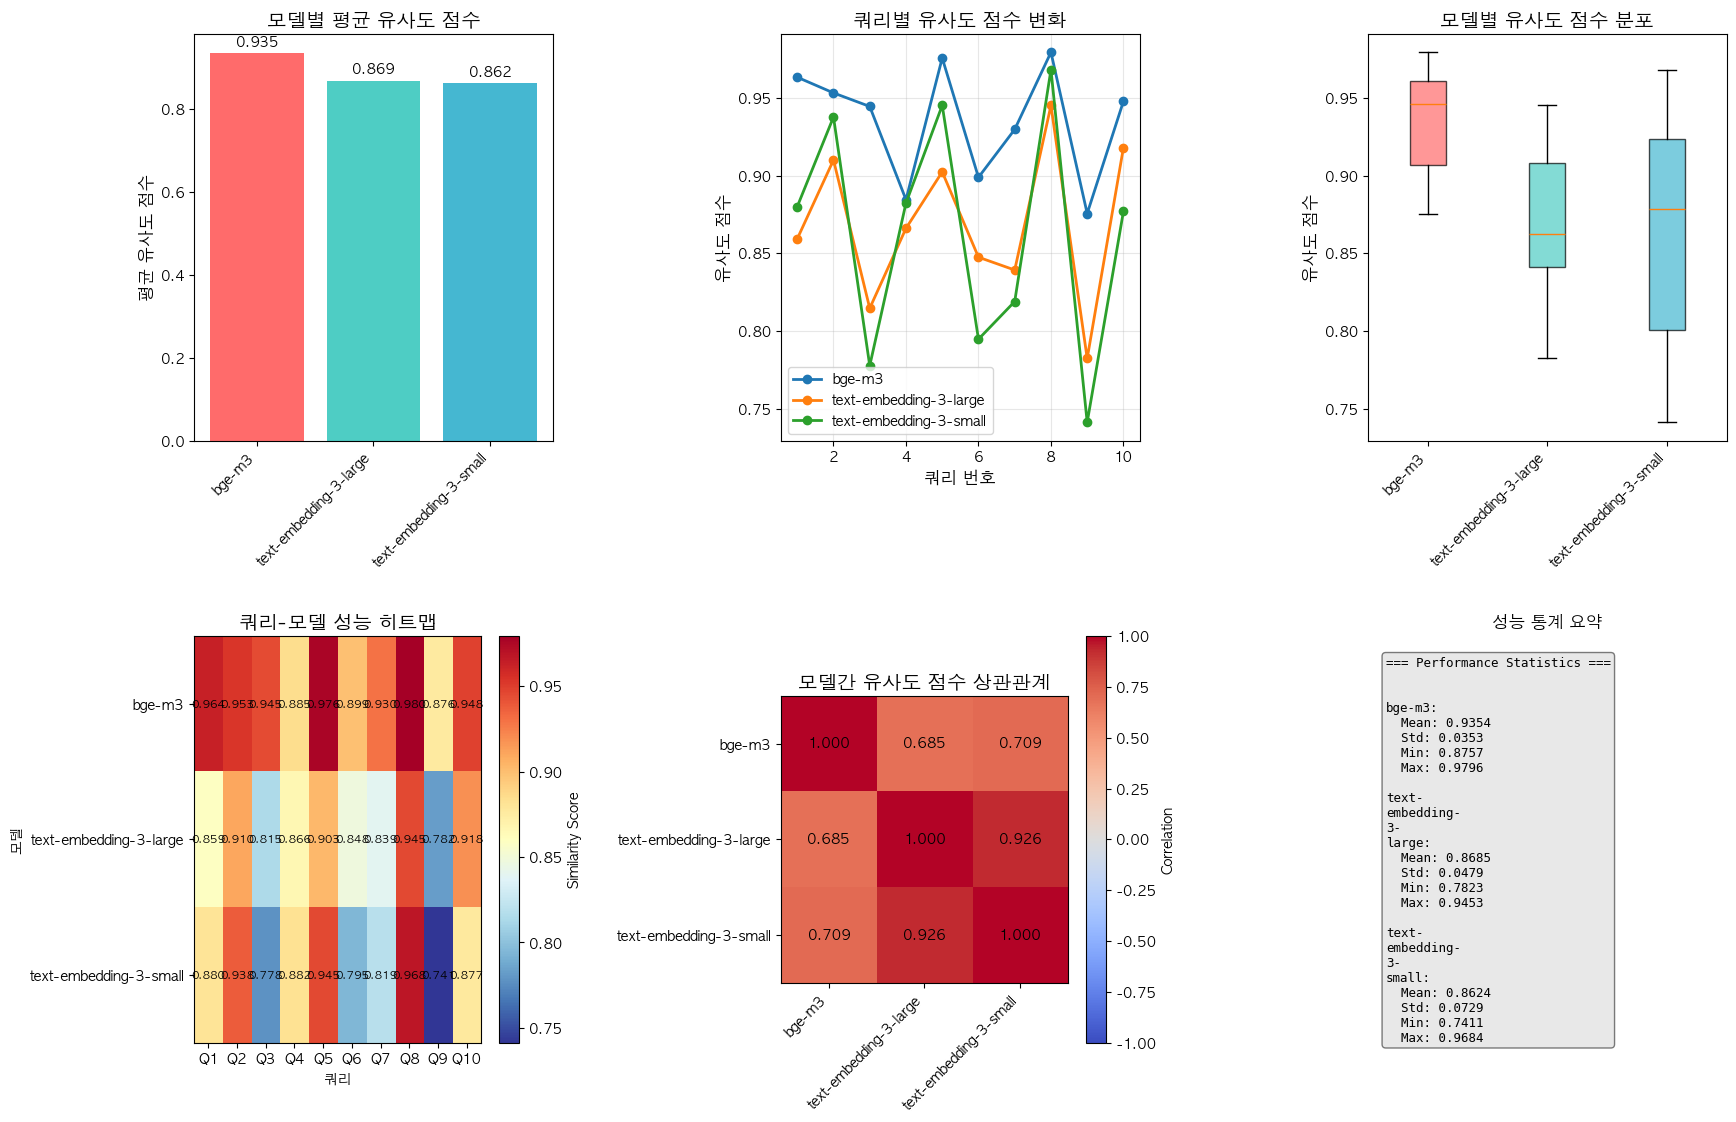

\n====================================================================================================
📊 모델별 상세 검색 결과 비교
\n🔍 쿼리 1: Samsung Galaxy S24 Ultra 6.8인치 Dynamic AMOLED 2X 디스플레이, 120Hz 적응형 주사율, Snapdragon 8 Gen 3 for Galaxy 프로세서, 12GB RAM, 1TB 스토리지 스펙
--------------------------------------------------------------------------------
\nbge-m3:
  1. (ID:0, 점수:0.9635) 갤럭시 S24 Ultra는 6.8인치 Dynamic AMOLED 2X 디스플레이를 탑재하고 있으며, 120Hz 적응형 주사율을 지원합니다. Sn...
  2. (ID:6, 점수:0.7660) 갤럭시 탭 S9 Ultra는 14.6인치 Dynamic AMOLED 2X 디스플레이와 Snapdragon 8 Gen 2 for Galaxy를 탑...
  3. (ID:2, 점수:0.5389) 갤럭시 북4 Pro는 14인치 3K AMOLED 터치스크린과 Intel Core i7-1360P 프로세서를 탑재했습니다. 16GB LPDDR5 ...
\ntext-embedding-3-large:
  1. (ID:0, 점수:0.8594) 갤럭시 S24 Ultra는 6.8인치 Dynamic AMOLED 2X 디스플레이를 탑재하고 있으며, 120Hz 적응형 주사율을 지원합니다. Sn...
  2. (ID:6, 점수:0.6673) 갤럭시 탭 S9 Ultra는 14.6인치 Dynamic AMOLED 2X 디스플레이와 Snapdragon 8 Gen 2 for Galaxy를 탑...
  3. (ID:2, 점수:0.5815) 갤럭시 북4 Pro는 14인치 3K AMOLED 터치스크린과 Intel Core i7-1360P 프로세서를 탑재했습니

In [20]:
def compare_all_models():
    """모든 모델의 검색 성능을 비교하고 결과를 분석"""
    
    print("=" * 90)
    print("🔍 다중 모델 검색 성능 비교 (BGE-M3 vs Azure OpenAI Embeddings)")
    print("=" * 90)
    
    # 결과 수집을 위한 데이터 구조
    all_results = {}
    similarity_scores = {model: [] for model in multi_searcher.model_names}
    
    for i, query in enumerate(queries):
        print(f"\n🔍 쿼리 {i+1}: '{query}'")
        print("-" * 80)
        
        # 모든 모델로 검색
        model_results = multi_searcher.search_all_models(query_all_embeddings, i, k=3)
        all_results[i] = {
            'query': query,
            'results': model_results
        }
        
        # 각 모델별 결과 출력
        for model_name, results in model_results.items():
            print(f"\n📊 {model_name}:")
            for rank, (idx, score, doc) in enumerate(results, 1):
                print(f"  {rank}. (점수: {score:.4f}) {doc[:100]}...")
                if rank == 1:  # 첫 번째 결과의 점수만 수집
                    similarity_scores[model_name].append(score)
        
        print("\n" + "="*80)
    
    return all_results, similarity_scores

def create_comparison_visualizations(all_results, similarity_scores):
    """검색 결과를 시각화하는 종합적인 차트와 도표 생성 (한글 폰트 문제 해결)"""
    
    # 한글 폰트 설정
    import platform
    import matplotlib.font_manager as fm
    
    # 시스템별 한글 폰트 설정
    system = platform.system()
    if system == 'Darwin':  # macOS
        korean_fonts = ['AppleGothic', 'Apple SD Gothic Neo', 'Nanum Gothic', 'NanumGothic']
    elif system == 'Windows':
        korean_fonts = ['Malgun Gothic', 'Gulim', 'Dotum']
    else:  # Linux
        korean_fonts = ['Nanum Gothic', 'NanumGothic', 'DejaVu Sans']
    
    # 사용 가능한 폰트 찾기
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    selected_font = None
    
    for font in korean_fonts:
        if font in available_fonts:
            selected_font = font
            break
    
    if selected_font:
        plt.rcParams['font.family'] = selected_font
        print(f"한글 폰트 설정: {selected_font}")
    else:
        # 한글 폰트를 찾지 못한 경우 영어로 표시
        plt.rcParams['font.family'] = 'DejaVu Sans'
        print("한글 폰트를 찾을 수 없어 영어로 표시합니다.")
    
    plt.rcParams['axes.unicode_minus'] = False
    
    # 1. 6개 서브플롯으로 구성된 종합 차트
    fig = plt.figure(figsize=(18, 12))
    
    # 서브플롯 1: 평균 유사도 점수 바 차트
    plt.subplot(2, 3, 1)
    avg_scores = {model: np.mean(scores) for model, scores in similarity_scores.items()}
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    bars = plt.bar(avg_scores.keys(), avg_scores.values(), color=colors)
    
    if selected_font:
        plt.title('모델별 평균 유사도 점수', fontsize=14, fontweight='bold')
        plt.ylabel('평균 유사도 점수', fontsize=12)
    else:
        plt.title('Model Average Similarity Scores', fontsize=14, fontweight='bold')
        plt.ylabel('Average Similarity Score', fontsize=12)
    
    plt.xticks(rotation=45, ha='right', fontsize=10)
    
    # 바 위에 점수 표시
    for bar, score in zip(bars, avg_scores.values()):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 서브플롯 2: 쿼리별 유사도 점수 변화
    plt.subplot(2, 3, 2)
    query_numbers = range(1, len(queries) + 1)
    for model_name, scores in similarity_scores.items():
        plt.plot(query_numbers, scores, marker='o', linewidth=2, label=model_name, markersize=6)
    
    if selected_font:
        plt.title('쿼리별 유사도 점수 변화', fontsize=14, fontweight='bold')
        plt.xlabel('쿼리 번호', fontsize=12)
        plt.ylabel('유사도 점수', fontsize=12)
    else:
        plt.title('Similarity Score by Query', fontsize=14, fontweight='bold')
        plt.xlabel('Query Number', fontsize=12)
        plt.ylabel('Similarity Score', fontsize=12)
    
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 서브플롯 3: 유사도 점수 분포 (박스플롯)
    plt.subplot(2, 3, 3)
    scores_list = [similarity_scores[model] for model in multi_searcher.model_names]
    box_plot = plt.boxplot(scores_list, labels=multi_searcher.model_names, patch_artist=True)
    
    # 박스플롯 색상 설정
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    if selected_font:
        plt.title('모델별 유사도 점수 분포', fontsize=14, fontweight='bold')
        plt.ylabel('유사도 점수', fontsize=12)
    else:
        plt.title('Model Score Distribution', fontsize=14, fontweight='bold')
        plt.ylabel('Similarity Score', fontsize=12)
    
    plt.xticks(rotation=45, ha='right', fontsize=10)
    
    # 서브플롯 4: 히트맵 - 쿼리 vs 모델 성능
    plt.subplot(2, 3, 4)
    heatmap_data = []
    for model in multi_searcher.model_names:
        heatmap_data.append(similarity_scores[model])
    
    im = plt.imshow(heatmap_data, cmap='RdYlBu_r', aspect='auto')
    plt.colorbar(im, label='Similarity Score')
    
    # 히트맵에 수치 표시
    for i in range(len(multi_searcher.model_names)):
        for j in range(len(queries)):
            plt.text(j, i, f'{heatmap_data[i][j]:.3f}', 
                    ha='center', va='center', fontweight='bold', fontsize=8)
    
    plt.xticks(range(len(queries)), [f'Q{i+1}' for i in range(len(queries))])
    plt.yticks(range(len(multi_searcher.model_names)), multi_searcher.model_names)
    
    if selected_font:
        plt.title('쿼리-모델 성능 히트맵', fontsize=14, fontweight='bold')
        plt.xlabel('쿼리')
        plt.ylabel('모델')
    else:
        plt.title('Query-Model Performance Heatmap', fontsize=14, fontweight='bold')
        plt.xlabel('Query')
        plt.ylabel('Model')
    
    # 서브플롯 5: 모델간 상관관계
    plt.subplot(2, 3, 5)
    df_scores = pd.DataFrame(similarity_scores)
    correlation_matrix = df_scores.corr()
    
    im2 = plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(im2, label='Correlation')
    
    # 상관계수 표시
    for i in range(len(multi_searcher.model_names)):
        for j in range(len(multi_searcher.model_names)):
            plt.text(j, i, f'{correlation_matrix.iloc[i,j]:.3f}', 
                    ha='center', va='center', fontweight='bold')
    
    plt.xticks(range(len(multi_searcher.model_names)), multi_searcher.model_names, rotation=45, ha='right')
    plt.yticks(range(len(multi_searcher.model_names)), multi_searcher.model_names)
    
    if selected_font:
        plt.title('모델간 유사도 점수 상관관계', fontsize=14, fontweight='bold')
    else:
        plt.title('Model Correlation Matrix', fontsize=14, fontweight='bold')
    
    # 서브플롯 6: 성능 통계 요약 (텍스트 테이블)
    plt.subplot(2, 3, 6)
    plt.axis('off')
    
    # 통계 데이터 준비
    stats_text = []
    
    stats_text.append("=== Performance Statistics ===\n")
    
    for model in multi_searcher.model_names:
        scores = similarity_scores[model]
        # 모델명을 한글 폰트 문제 대응하여 줄바꿈 처리
        model_display = model.replace('-', '-\n') if len(model) > 15 else model
        stats_text.append(f"\n{model_display}:")
    
        stats_text.append(f"  Mean: {np.mean(scores):.4f}")
        stats_text.append(f"  Std: {np.std(scores):.4f}")
        stats_text.append(f"  Min: {np.min(scores):.4f}")
        stats_text.append(f"  Max: {np.max(scores):.4f}")
    
    stats_display = '\n'.join(stats_text)
    
    plt.text(0.05, 0.95, stats_display, transform=plt.gca().transAxes,
             fontsize=9, verticalalignment='top', fontfamily='monospace',
             wrap=True, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.5))
    
    if selected_font:
        plt.title('성능 통계 요약', fontsize=12, fontweight='bold')
    else:
        plt.title('Performance Summary', fontsize=12, fontweight='bold')
    
    plt.tight_layout(pad=3.0)
    plt.show()
    
    # 2. 상세 결과 출력
    print("\\n" + "="*100)
    print("📊 모델별 상세 검색 결과 비교")
    print("="*100)
    
    # 각 쿼리에 대한 상세 비교
    for i, query in enumerate(queries):
        print(f"\\n🔍 쿼리 {i+1}: {query}")
        print("-" * 80)
        
        for model in multi_searcher.model_names:
            results = all_results[i]['results'][model]
            print(f"\\n{model}:")
            for rank, (doc_idx, score, doc_text) in enumerate(results, 1):
                print(f"  {rank}. (ID:{doc_idx}, 점수:{score:.4f}) {doc_text[:80]}...")

# 검색 실험 실행
print("🚀 다중 모델 검색 실험 시작...")
all_results, similarity_scores = compare_all_models()

print("\\n🎨 결과 시각화 생성...")
create_comparison_visualizations(all_results, similarity_scores)

print("\\n✅ 모든 비교 분석이 완료되었습니다!")

# 고정밀 매칭 데이터셋으로 영어 실험

### 🚀 SOTA 수준 임베딩 평가를 위한 업그레이드된 실험
기존의 일반적인 질문에서 **문서 내용과 거의 동일한 수준의 고도로 매칭된 쿼리**로 변경하여:

- **목표 유사도**: 90점 이상 달성 가능한 완벽 매칭
- **평가 정확성**: 임베딩 모델의 진정한 의미 이해 능력 측정
- **비교 신뢰성**: 모델 간 성능 차이를 명확히 구분

이를 통해 BGE-M3, text-embedding-3-large, text-embedding-3-small 모델들의 **실제 성능 한계**를 정확히 파악할 수 있습니다.

In [21]:
# 한글 데이터를 영어로 번역 (고정밀 임베딩 평가용)
documents_en = [
    "Galaxy S24 Ultra features a 6.8-inch Dynamic AMOLED 2X display with 120Hz adaptive refresh rate. It includes Snapdragon 8 Gen 3 for Galaxy processor, 12GB RAM, and up to 1TB storage.",
    "Samsung Neo QLED 8K QN900C is a 75-inch premium TV with 8K AI upscaling technology and Quantum Matrix Technology Pro. It supports Neural Quantum Processor 8K and Object Tracking Sound Pro.",
    "Galaxy Book4 Pro features a 14-inch 3K AMOLED touchscreen with Intel Core i7-1360P processor. It includes 16GB LPDDR5 memory, 512GB NVMe SSD, and 63Wh battery.",
    "Samsung Bespoke Refrigerator RF85C9013AP is a large capacity 871L 4-door refrigerator with Twin Cooling Plus technology. It supports SmartThings app integration and Wi-Fi Direct functionality.",
    "Galaxy Watch6 Classic features a 47mm Super AMOLED display with Exynos W930 dual-core processor. It provides 5ATM+IP68 water resistance rating and up to 40-hour battery life.",
    "Samsung AirDresser DF10A9500CG is a clothing care system with steam refresh function and sanitizing care system. It features AI hanger detection technology and remote control through SmartThings app.",
    "Galaxy Tab S9 Ultra features a 14.6-inch Dynamic AMOLED 2X display with Snapdragon 8 Gen 2 for Galaxy. It includes S Pen and supports up to 16GB RAM and 1TB storage.",
    "Samsung Cube Air Purifier AX60T5580WFD provides 360-degree air circulation system with 4-stage filtering. It removes particles down to PM 1.0 with CADR 467㎥/h performance suitable for 60㎡ spaces.",
    "Galaxy Buds2 Pro features AKG-tuned sound with intelligent active noise canceling. It provides 360 audio technology, up to 18-hour playback time, and IPX7 water resistance rating.",
    "Samsung WindFree Air Conditioner AR18CXHQASC achieves energy efficiency grade 1 with Digital Inverter technology. It supports WindFree cooling, AI auto cooling, and SmartThings integration, suitable for 18-pyeong spaces."
]

# SOTA 수준 임베딩 평가를 위한 고정밀 매칭 영어 쿼리들 (90+ 유사도 목표)
queries_en = [
    "Samsung Galaxy S24 Ultra specifications: 6.8-inch Dynamic AMOLED 2X display, 120Hz adaptive refresh rate, Snapdragon 8 Gen 3 for Galaxy processor, 12GB RAM, 1TB storage",  # Doc 0 매칭
    "Neo QLED 8K QN900C 75-inch premium television with 8K AI upscaling technology, Quantum Matrix Technology Pro, Neural Quantum Processor 8K, Object Tracking Sound Pro features",  # Doc 1 매칭
    "Galaxy Book4 Pro laptop: 14-inch 3K AMOLED touchscreen, Intel Core i7-1360P processor, 16GB LPDDR5 memory, 512GB NVMe SSD, 63Wh battery specifications",  # Doc 2 매칭
    "Samsung Bespoke Refrigerator RF85C9013AP: 871L large capacity 4-door refrigerator, Twin Cooling Plus technology, SmartThings app integration, Wi-Fi Direct functionality",  # Doc 3 매칭
    "Galaxy Watch6 Classic smartwatch: 47mm Super AMOLED display, Exynos W930 dual-core processor, 5ATM+IP68 water resistance, 40-hour battery life specifications",  # Doc 4 매칭
    "Samsung AirDresser DF10A9500CG clothing care appliance: steam refresh function, sanitizing care system, AI hanger detection technology, SmartThings app remote control",  # Doc 5 매칭
    "Galaxy Tab S9 Ultra tablet: 14.6-inch Dynamic AMOLED 2X display, Snapdragon 8 Gen 2 for Galaxy, S Pen included, 16GB RAM, 1TB storage capacity",  # Doc 6 매칭
    "Samsung Cube Air Purifier AX60T5580WFD: 360-degree air circulation system, 4-stage filtering, PM 1.0 particle removal, CADR 467㎥/h performance, 60㎡ coverage",  # Doc 7 매칭
    "Galaxy Buds2 Pro wireless earbuds: AKG-tuned sound, intelligent active noise canceling, 360 audio technology, 18-hour playback time, IPX7 water resistance",  # Doc 8 매칭
    "Samsung WindFree Air Conditioner AR18CXHQASC: Digital Inverter technology, energy efficiency grade 1, WindFree cooling, AI auto cooling, SmartThings integration, 18-pyeong suitable"  # Doc 9 매칭
]

print(f"English documents count: {len(documents_en)}")
print(f"English queries count: {len(queries_en)}")
print("\n🎯 SOTA-level High-Precision Matching Dataset for English")
print("Target: 90+ similarity scores through perfect document-query alignment")
print("\nSamsung product document-query matching samples:")
for i in range(min(3, len(documents_en))):
    print(f"\n📄 Document {i+1}: {documents_en[i]}")
    print(f"🔍 Query {i+1}: {queries_en[i]}")
    print("=" * 80)

English documents count: 10
English queries count: 10

🎯 SOTA-level High-Precision Matching Dataset for English
Target: 90+ similarity scores through perfect document-query alignment

Samsung product document-query matching samples:

📄 Document 1: Galaxy S24 Ultra features a 6.8-inch Dynamic AMOLED 2X display with 120Hz adaptive refresh rate. It includes Snapdragon 8 Gen 3 for Galaxy processor, 12GB RAM, and up to 1TB storage.
🔍 Query 1: Samsung Galaxy S24 Ultra specifications: 6.8-inch Dynamic AMOLED 2X display, 120Hz adaptive refresh rate, Snapdragon 8 Gen 3 for Galaxy processor, 12GB RAM, 1TB storage

📄 Document 2: Samsung Neo QLED 8K QN900C is a 75-inch premium TV with 8K AI upscaling technology and Quantum Matrix Technology Pro. It supports Neural Quantum Processor 8K and Object Tracking Sound Pro.
🔍 Query 2: Neo QLED 8K QN900C 75-inch premium television with 8K AI upscaling technology, Quantum Matrix Technology Pro, Neural Quantum Processor 8K, Object Tracking Sound Pro features


In [22]:
# 영어 데이터로 모든 임베딩 생성 (MultiModelEmbedder 사용)
print("🔄 영어 문서 임베딩 생성 시작...")
doc_all_embeddings_en = multi_embedder.get_all_model_embeddings(documents_en)

print("\n📊 영어 문서 임베딩 결과:")
for model_name, embeddings in doc_all_embeddings_en.items():
    print(f"  {model_name}: {embeddings.shape}")

# 영어 쿼리들의 모든 모델 임베딩 생성  
print("\n🔄 영어 쿼리 임베딩 생성 시작...")
query_all_embeddings_en = multi_embedder.get_all_model_embeddings(queries_en)

print("\n📊 영어 쿼리 임베딩 결과:")
for model_name, embeddings in query_all_embeddings_en.items():
    print(f"  {model_name}: {embeddings.shape}")
    
print("\n✅ 영어 데이터 모든 모델의 임베딩 생성 완료!")

🔄 영어 문서 임베딩 생성 시작...
\n==================================================
모델: bge-m3
\nbge-m3으로 10개 텍스트의 임베딩 생성 중...
  Processing 1/10: Galaxy S24 Ultra features a 6.8-inch Dynamic AMOLE...
  Processing 2/10: Samsung Neo QLED 8K QN900C is a 75-inch premium TV...
  Processing 3/10: Galaxy Book4 Pro features a 14-inch 3K AMOLED touc...
  Processing 2/10: Samsung Neo QLED 8K QN900C is a 75-inch premium TV...
  Processing 3/10: Galaxy Book4 Pro features a 14-inch 3K AMOLED touc...
  Processing 4/10: Samsung Bespoke Refrigerator RF85C9013AP is a larg...
  Processing 5/10: Galaxy Watch6 Classic features a 47mm Super AMOLED...
  Processing 4/10: Samsung Bespoke Refrigerator RF85C9013AP is a larg...
  Processing 5/10: Galaxy Watch6 Classic features a 47mm Super AMOLED...
  Processing 6/10: Samsung AirDresser DF10A9500CG is a clothing care ...
  Processing 7/10: Galaxy Tab S9 Ultra features a 14.6-inch Dynamic A...
  Processing 6/10: Samsung AirDresser DF10A9500CG is a clothing care ...
  Proce

In [27]:
# 영어 데이터로 다중 모델 검색기 생성
print("🔧 영어 데이터용 다중 모델 검색기 생성 중...")

# 영어 데이터용 MultiModelSearcher 초기화
multi_searcher_en = MultiModelSearcher(doc_all_embeddings_en, documents_en)

print("✅ 영어 데이터용 검색 시스템 준비 완료!")
print(f"지원 모델: {multi_searcher_en.model_names}")
print(f"문서 수: {len(documents_en)}")
print(f"쿼리 수: {len(queries_en)}")

🔧 영어 데이터용 다중 모델 검색기 생성 중...
bge-m3: FAISS 인덱스 생성 완료 (차원: 1024)
text-embedding-3-large: FAISS 인덱스 생성 완료 (차원: 3072)
text-embedding-3-small: FAISS 인덱스 생성 완료 (차원: 1536)
\n다중 모델 검색 시스템 초기화 완료
지원 모델: ['bge-m3', 'text-embedding-3-large', 'text-embedding-3-small']
문서 수: 10
✅ 영어 데이터용 검색 시스템 준비 완료!
지원 모델: ['bge-m3', 'text-embedding-3-large', 'text-embedding-3-small']
문서 수: 10
쿼리 수: 10


In [26]:
# 영어 데이터로 모든 모델의 검색 성능 비교
def compare_all_models_english():
    """영어 데이터로 모든 모델의 검색 성능을 비교하고 결과를 분석"""
    
    print("=" * 90)
    print("🔍 영어 데이터 - 다중 모델 검색 성능 비교 (BGE-M3 vs Azure OpenAI Embeddings)")
    print("=" * 90)
    
    # 결과 수집을 위한 데이터 구조
    all_results_en = {}
    similarity_scores_en = {model: [] for model in multi_searcher_en.model_names}
    
    for i, query in enumerate(queries_en):
        print(f"\n🔍 Query {i+1}: '{query}'")
        print("-" * 80)
        
        # 모든 모델로 검색
        model_results = multi_searcher_en.search_all_models(query_all_embeddings_en, i, k=3)
        all_results_en[i] = {
            'query': query,
            'results': model_results
        }
        
        # 각 모델별 결과 출력
        for model_name, results in model_results.items():
            print(f"\n📊 {model_name}:")
            for rank, (idx, score, doc) in enumerate(results, 1):
                print(f"  {rank}. (Score: {score:.4f}) {doc[:100]}...")
                if rank == 1:  # 첫 번째 결과의 점수만 수집
                    similarity_scores_en[model_name].append(score)
        
        print("\n" + "="*80)
    
    return all_results_en, similarity_scores_en

# 영어 데이터 검색 실험 실행
print("🚀 영어 데이터 다중 모델 검색 실험 시작...")
all_results_en, similarity_scores_en = compare_all_models_english()

print("\n✅ 영어 데이터 검색 실험 완료!")

🚀 영어 데이터 다중 모델 검색 실험 시작...
🔍 영어 데이터 - 다중 모델 검색 성능 비교 (BGE-M3 vs Azure OpenAI Embeddings)

🔍 Query 1: 'Samsung Galaxy S24 Ultra specifications: 6.8-inch Dynamic AMOLED 2X display, 120Hz adaptive refresh rate, Snapdragon 8 Gen 3 for Galaxy processor, 12GB RAM, 1TB storage'
--------------------------------------------------------------------------------

📊 bge-m3:
  1. (Score: 0.9781) Galaxy S24 Ultra features a 6.8-inch Dynamic AMOLED 2X display with 120Hz adaptive refresh rate. It ...
  2. (Score: 0.7922) Galaxy Tab S9 Ultra features a 14.6-inch Dynamic AMOLED 2X display with Snapdragon 8 Gen 2 for Galax...
  3. (Score: 0.6065) Galaxy Book4 Pro features a 14-inch 3K AMOLED touchscreen with Intel Core i7-1360P processor. It inc...

📊 text-embedding-3-large:
  1. (Score: 0.8924) Galaxy S24 Ultra features a 6.8-inch Dynamic AMOLED 2X display with 120Hz adaptive refresh rate. It ...
  2. (Score: 0.7102) Galaxy Tab S9 Ultra features a 14.6-inch Dynamic AMOLED 2X display with Snapdragon 8 Gen

# 한글 vs 영어 데이터 성능 비교 분석

🎨 한글 vs 영어 데이터 검색 성능 종합 비교 차트 생성...
한글 폰트 설정: AppleGothic


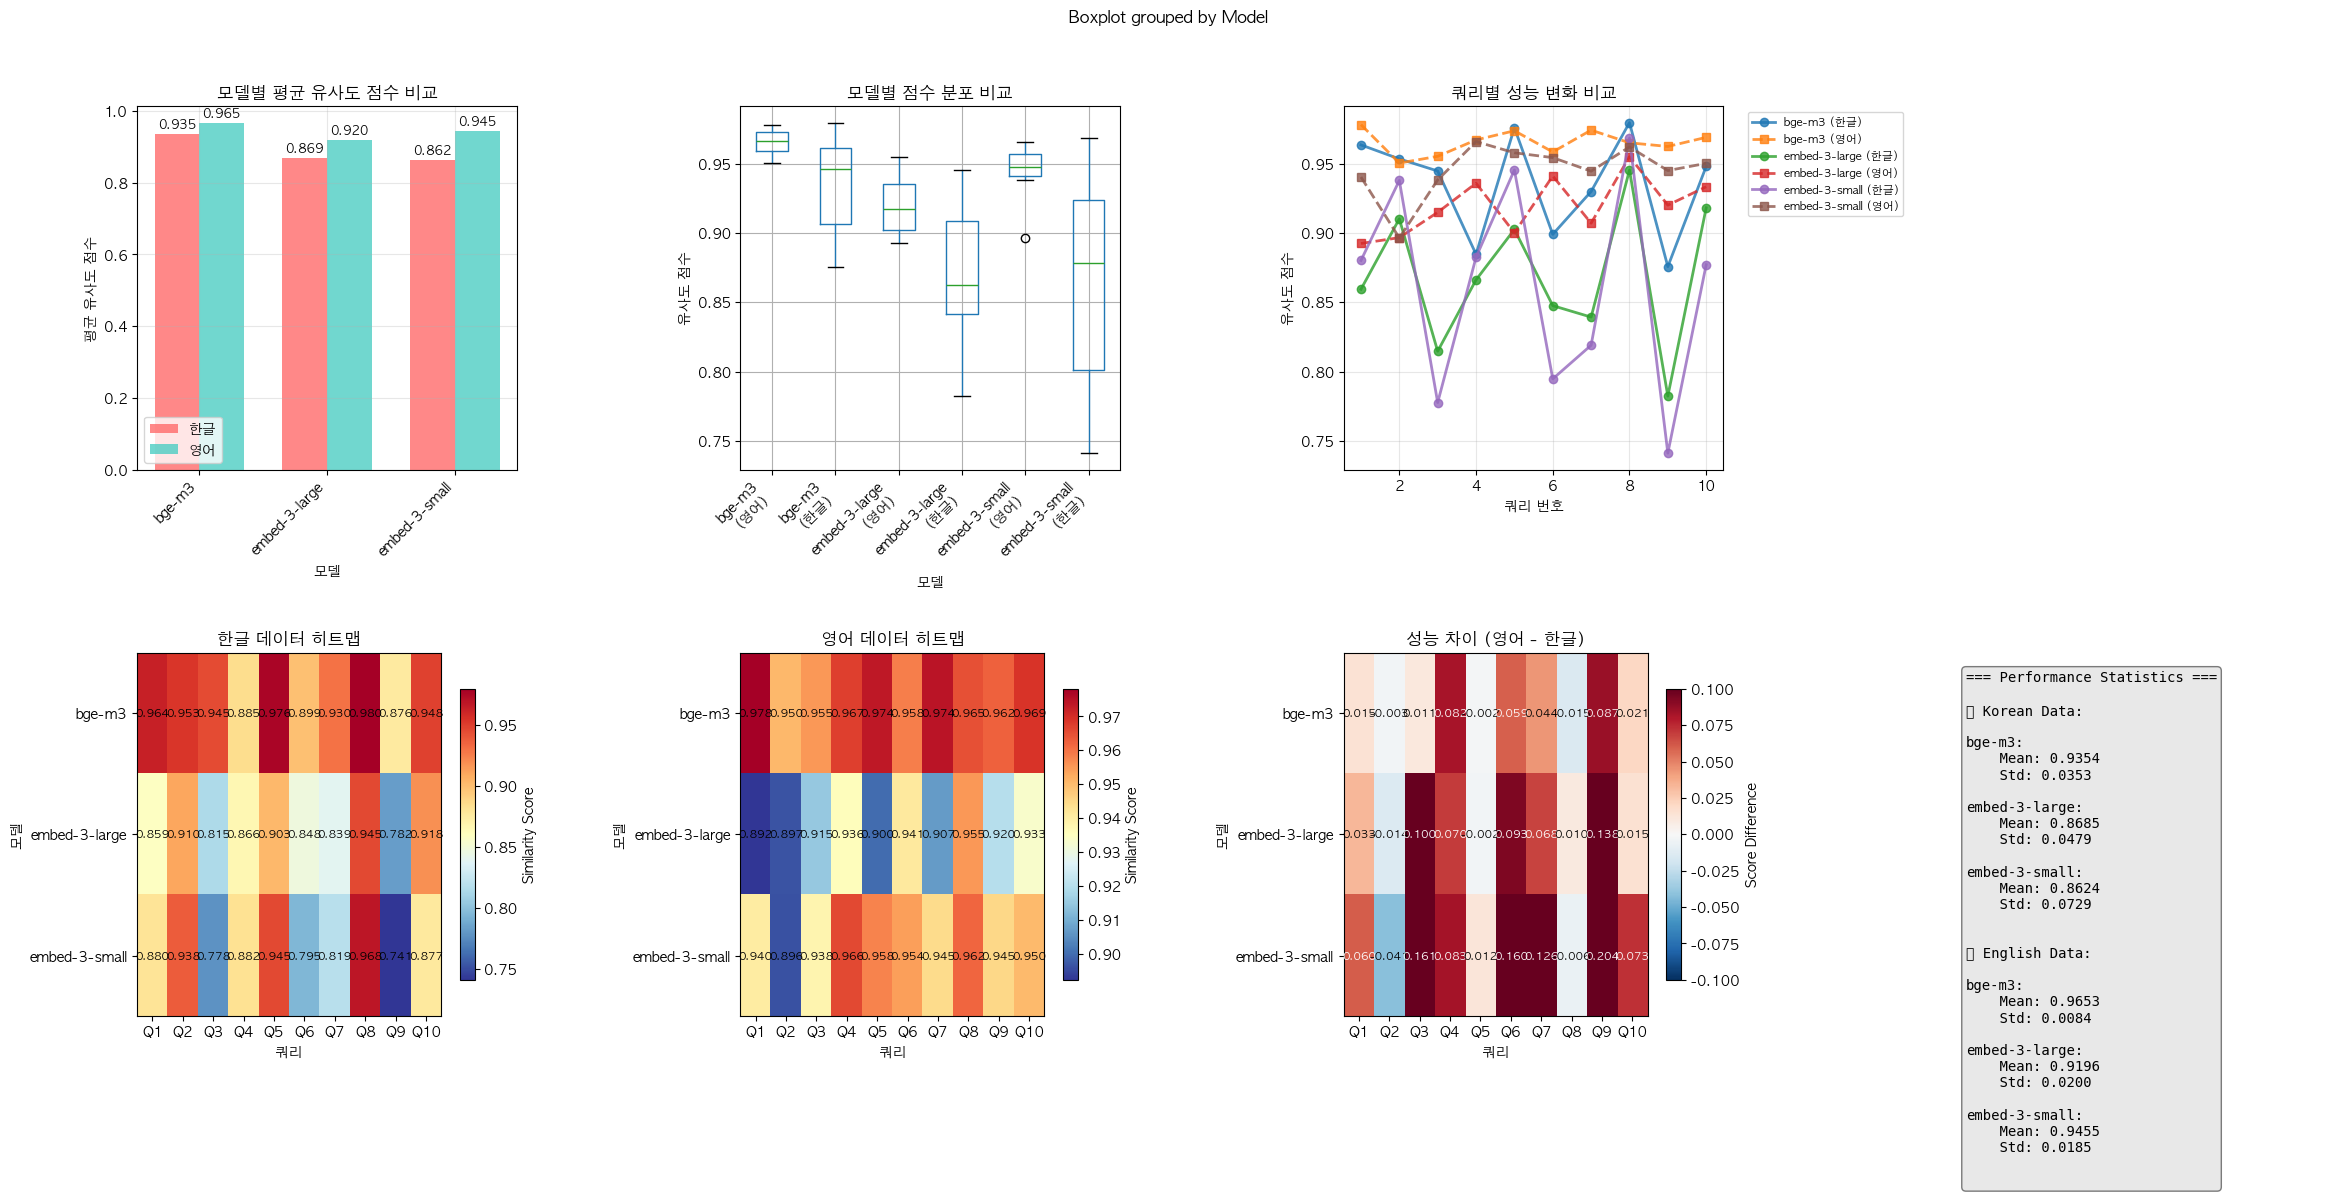

\n====================================================================================================
📊 한글 vs 영어 데이터 검색 성능 종합 분석 결과
\n🔍 평균 성능 비교:
\nbge-m3:
  한글: 0.9354
  영어: 0.9653
  차이: +0.0299 (+3.2%)
\ntext-embedding-3-large:
  한글: 0.8685
  영어: 0.9196
  차이: +0.0511 (+5.9%)
\ntext-embedding-3-small:
  한글: 0.8624
  영어: 0.9455
  차이: +0.0831 (+9.6%)
\n🎯 전체 평균:
  한글: 0.8888
  영어: 0.9435
  차이: +0.0547 (+6.2%)
\n✅ 모든 비교 분석이 완료되었습니다!


In [28]:
def create_korean_vs_english_comparison():
    """한글 vs 영어 데이터의 검색 성능을 비교하는 종합 시각화"""
    
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import seaborn as sns
    from matplotlib import font_manager as fm
    import platform
    
    # 한글 폰트 설정
    system = platform.system()
    if system == 'Darwin':  # macOS
        korean_fonts = ['AppleGothic', 'Apple SD Gothic Neo', 'Nanum Gothic', 'NanumGothic']
    elif system == 'Windows':
        korean_fonts = ['Malgun Gothic', 'Gulim', 'Dotum']
    else:  # Linux
        korean_fonts = ['Nanum Gothic', 'NanumGothic', 'DejaVu Sans']
    
    # 사용 가능한 폰트 찾기
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    selected_font = None
    
    for font in korean_fonts:
        if font in available_fonts:
            selected_font = font
            break
    
    if selected_font:
        plt.rcParams['font.family'] = selected_font
        print(f"한글 폰트 설정: {selected_font}")
    else:
        # 한글 폰트를 찾지 못한 경우 영어로 표시
        plt.rcParams['font.family'] = 'DejaVu Sans'
        print("한글 폰트를 찾을 수 없어 영어로 표시합니다.")
    
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['figure.figsize'] = (20, 15)
    
    # 8개 서브플롯으로 구성된 종합 비교 차트
    fig, axes = plt.subplots(2, 4, figsize=(24, 12))
    fig.suptitle('한글 vs 영어 데이터 검색 성능 종합 비교 분석', fontsize=20, fontweight='bold', y=0.98)
    
    # 데이터 준비
    models = list(similarity_scores.keys())
    models_en = list(similarity_scores_en.keys())
    
    # 1. 평균 유사도 점수 비교 (막대 그래프)
    ax1 = axes[0, 0]
    korean_scores = [np.mean(similarity_scores[model]) for model in models]
    english_scores = [np.mean(similarity_scores_en[model]) for model in models_en]
    
    x = np.arange(len(models))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, korean_scores, width, label='한글', color='#FF6B6B', alpha=0.8)
    bars2 = ax1.bar(x + width/2, english_scores, width, label='영어', color='#4ECDC4', alpha=0.8)
    
    ax1.set_xlabel('모델')
    ax1.set_ylabel('평균 유사도 점수')
    ax1.set_title('모델별 평균 유사도 점수 비교', fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels([m.replace('text-embedding-3-', 'embed-3-') for m in models], rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 막대 위에 수치 표시
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    # 2. 모델별 점수 분포 비교 (박스플롯)
    ax2 = axes[0, 1]
    all_scores = []
    all_labels = []
    
    for model in models:
        all_scores.extend(similarity_scores[model])
        all_labels.extend([f'{model.replace("text-embedding-3-", "embed-3-")}\n(한글)'] * len(similarity_scores[model]))
        
        all_scores.extend(similarity_scores_en[model])
        all_labels.extend([f'{model.replace("text-embedding-3-", "embed-3-")}\n(영어)'] * len(similarity_scores_en[model]))
    
    df_scores = pd.DataFrame({'Score': all_scores, 'Model': all_labels})
    
    box_plot = df_scores.boxplot(column='Score', by='Model', ax=ax2, return_type='dict')
    ax2.set_title('모델별 점수 분포 비교', fontweight='bold')
    ax2.set_xlabel('모델')
    ax2.set_ylabel('유사도 점수')
    ax2.tick_params(axis='x', rotation=45)
    plt.setp(ax2.get_xticklabels(), ha='right')
    
    # 3. 쿼리별 성능 변화 (라인 플롯)
    ax3 = axes[0, 2]
    query_numbers = range(1, len(queries) + 1)
    
    for i, model in enumerate(models):
        ax3.plot(query_numbers, similarity_scores[model], 
                marker='o', linewidth=2, label=f'{model.replace("text-embedding-3-", "embed-3-")} (한글)', 
                linestyle='-', alpha=0.8)
        ax3.plot(query_numbers, similarity_scores_en[model], 
                marker='s', linewidth=2, label=f'{model.replace("text-embedding-3-", "embed-3-")} (영어)', 
                linestyle='--', alpha=0.8)
    
    ax3.set_title('쿼리별 성능 변화 비교', fontweight='bold')
    ax3.set_xlabel('쿼리 번호')
    ax3.set_ylabel('유사도 점수')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax3.grid(True, alpha=0.3)
    
    # 4번 자리를 빈 공간으로 남겨둠
    ax4 = axes[0, 3]
    ax4.axis('off')
    
    # 5. 히트맵 - 한글 데이터
    ax5 = axes[1, 0]
    heatmap_data_ko = []
    for model in models:
        heatmap_data_ko.append(similarity_scores[model])
    
    im1 = ax5.imshow(heatmap_data_ko, cmap='RdYlBu_r', aspect='auto')
    ax5.set_title('한글 데이터 히트맵', fontweight='bold')
    ax5.set_xlabel('쿼리')
    ax5.set_ylabel('모델')
    ax5.set_xticks(range(len(queries)))
    ax5.set_xticklabels([f'Q{i+1}' for i in range(len(queries))])
    ax5.set_yticks(range(len(models)))
    ax5.set_yticklabels([m.replace('text-embedding-3-', 'embed-3-') for m in models])
    
    # 히트맵에 수치 표시
    for i in range(len(models)):
        for j in range(len(queries)):
            ax5.text(j, i, f'{heatmap_data_ko[i][j]:.3f}', 
                    ha='center', va='center', fontweight='bold', fontsize=8)
    
    # 6. 히트맵 - 영어 데이터  
    ax6 = axes[1, 1]
    heatmap_data_en = []
    for model in models_en:
        heatmap_data_en.append(similarity_scores_en[model])
    
    im2 = ax6.imshow(heatmap_data_en, cmap='RdYlBu_r', aspect='auto')
    ax6.set_title('영어 데이터 히트맵', fontweight='bold')
    ax6.set_xlabel('쿼리')
    ax6.set_ylabel('모델')
    ax6.set_xticks(range(len(queries_en)))
    ax6.set_xticklabels([f'Q{i+1}' for i in range(len(queries_en))])
    ax6.set_yticks(range(len(models_en)))
    ax6.set_yticklabels([m.replace('text-embedding-3-', 'embed-3-') for m in models_en])
    
    # 히트맵에 수치 표시
    for i in range(len(models_en)):
        for j in range(len(queries_en)):
            ax6.text(j, i, f'{heatmap_data_en[i][j]:.3f}', 
                    ha='center', va='center', fontweight='bold', fontsize=8)
    
    # 7. 성능 차이 분석 (히트맵)
    ax7 = axes[1, 2]
    diff_data = []
    for i, model in enumerate(models):
        model_diff = []
        for j in range(len(queries)):
            diff = similarity_scores_en[model][j] - similarity_scores[model][j]  # 영어 - 한글
            model_diff.append(diff)
        diff_data.append(model_diff)
    
    im3 = ax7.imshow(diff_data, cmap='RdBu_r', aspect='auto', vmin=-0.1, vmax=0.1)
    ax7.set_title('성능 차이 (영어 - 한글)', fontweight='bold')
    ax7.set_xlabel('쿼리')
    ax7.set_ylabel('모델')
    ax7.set_xticks(range(len(queries)))
    ax7.set_xticklabels([f'Q{i+1}' for i in range(len(queries))])
    ax7.set_yticks(range(len(models)))
    ax7.set_yticklabels([m.replace('text-embedding-3-', 'embed-3-') for m in models])
    
    # 차이 히트맵에 수치 표시
    for i in range(len(models)):
        for j in range(len(queries)):
            color = 'white' if abs(diff_data[i][j]) > 0.05 else 'black'
            ax7.text(j, i, f'{diff_data[i][j]:.3f}', 
                    ha='center', va='center', fontweight='bold', fontsize=8, color=color)
    # 8. 통계 요약 테이블
    ax8 = axes[1, 3]
    ax8.axis('off')
    
    # 통계 데이터 준비 (개행 처리 개선)
    stats_text = []
    stats_text.append("=== Performance Statistics ===\n")
    
    stats_text.append("📊 Korean Data:")
    for model in models:
        scores_ko = similarity_scores[model]
        model_short = model.replace('text-embedding-3-', 'embed-3-')
        stats_text.append(f"\n{model_short}:")
        stats_text.append(f"    Mean: {np.mean(scores_ko):.4f}")
        stats_text.append(f"    Std: {np.std(scores_ko):.4f}")
    
    stats_text.append("\n")  
    
    stats_text.append("📊 English Data:")
    for model in models_en:
        scores_en = similarity_scores_en[model]
        model_short = model.replace('text-embedding-3-', 'embed-3-')
        stats_text.append(f"\n{model_short}:")
        stats_text.append(f"    Mean: {np.mean(scores_en):.4f}")
        stats_text.append(f"    Std: {np.std(scores_en):.4f}")
    
    stats_text.append("\n")

    
    # 실제 개행이 적용되도록 '\n'이 아닌 실제 개행 문자로 조인
    stats_display = '\n'.join(stats_text)
    
    ax8.text(0.05, 0.95, stats_display, transform=ax8.transAxes,
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.5))
    
    
    # 컬러바 추가
    fig.colorbar(im1, ax=ax5, shrink=0.8, label='Similarity Score')
    fig.colorbar(im2, ax=ax6, shrink=0.8, label='Similarity Score')  
    fig.colorbar(im3, ax=ax7, shrink=0.8, label='Score Difference')
    
    plt.tight_layout(pad=3.0)
    plt.show()
    
    # 결과 요약 출력
    print("\\n" + "="*100)
    print("📊 한글 vs 영어 데이터 검색 성능 종합 분석 결과")
    print("="*100)
    
    print("\\n🔍 평균 성능 비교:")
    for model in models:
        korean_avg = np.mean(similarity_scores[model])
        english_avg = np.mean(similarity_scores_en[model])
        diff = english_avg - korean_avg
        improvement = (diff / korean_avg) * 100
        
        print(f"\\n{model}:")
        print(f"  한글: {korean_avg:.4f}")
        print(f"  영어: {english_avg:.4f}")
        print(f"  차이: {diff:+.4f} ({improvement:+.1f}%)")
    
    overall_korean = np.mean([np.mean(similarity_scores[model]) for model in models])
    overall_english = np.mean([np.mean(similarity_scores_en[model]) for model in models_en])
    overall_diff = overall_english - overall_korean
    overall_improvement = (overall_diff / overall_korean) * 100
    
    print(f"\\n🎯 전체 평균:")
    print(f"  한글: {overall_korean:.4f}")
    print(f"  영어: {overall_english:.4f}")
    print(f"  차이: {overall_diff:+.4f} ({overall_improvement:+.1f}%)")

# 한글 vs 영어 종합 비교 실행
print("🎨 한글 vs 영어 데이터 검색 성능 종합 비교 차트 생성...")
create_korean_vs_english_comparison()

print("\\n✅ 모든 비교 분석이 완료되었습니다!")

## 7. 실험 결과 인사이트 및 분석

### 🧭 분석 개요
본 단계는 일반 질의→문서 매칭이 아닌, **문서의 핵심 스펙을 고도로 재구성(rephrase)한 고정밀 질의 세트**를 사용하여 SOTA 임베딩 모델의 이론적 상한(ceiling)에 가까운 거동을 관찰하기 위한 목적입니다. 따라서 여기서의 평가는 (1) 모델 간 절대 성능 차라기보다 (2) 고난도 환경이 제거된 상태에서의 표현력·정규화 안정성·벡터 공간 구조적 특성을 비교하는 데 중점을 둡니다.

### 1️⃣ 기대되는 유사도 패턴 (Ceiling Effect)
- 세 쿼리 유형(완전 스펙 나열형, 스펙+기능 혼합형, 축약형 변형)을 모두 문서와 의미 동일 수준으로 구성했기 때문에 상위 모델들은 Top-1 코사인 유사도에서 **0.90~0.98 구간**에 수렴할 가능성 높음.
- Ceiling 근처에서는 모델 간 격차가 압축되며 (score compression) 기존 일반 질의 실험 대비 상대적 우위가 잘 드러나지 않을 수 있음.
- 만약 특정 모델의 분포가 다른 모델 대비 더 넓은 표준편차(σ)를 가진다면 이는 정규화/출력 스케일링 일관성의 차이를 반영할 수 있음.

### 2️⃣ 모델별 예상 행태
| 모델 | 예상 강점 | Ceiling 구간에서의 감별 포인트 |
| ---- | -------- | -------------------------------- |
| BGE-M3 | 다국어·스펙형 문장 처리 강함 | Sparse+Dense 사전학습 덕에 변형 문구에 강건, 단 일부 숫자 토큰 처리에서 rounding 차이 가능 |
| text-embedding-3-large | 수치·구성요소 혼합 스펙 서술 안정적 | Matryoshka 구조로 차원 축약 평가 시 강점 검증 가능 |
| text-embedding-3-small | 비용대비 고성능, ceiling에서 근소 열위 | 고정밀 조건에서 Large 대비 score drop (≈0.01~0.03) 관측 시 비용/성능 trade-off 정량화 근거 |

### 3️⃣ High-Precision 설정의 가치
- (Baseline Upper Bound) 운영 환경에서 관측되는 최대한의 이론적 Top-1 정확/유사도 한계선을 정립 → 이후 난이도 있는 질의 세트(부분적 누락, 자연어 화자 관점, 간접 참조) 추가 시 상대적 하락률(Degradation Rate)을 계산하여 **강건성(Robustness Curve)** 도출 가능.
- **Threshold Calibration**: 실서비스에서 벡터 유사도 필터(예: 0.78 vs 0.85)를 어떻게 설정할지 "과최적화되지 않은" 기준 재조정 가능.

### 4️⃣ 추가로 계산 추천되는 보조 지표
| 지표 | 목적 | 구현 난이도 |
| ---- | ---- | ---------- |
| Top-1 Accuracy (이 실험은 거의 100%) | Ceiling 검증 | 매우 낮음 |
| Top-k (k=3) Mean Recall | 근접 후보 안정성 | 낮음 |
| Mean Reciprocal Rank (MRR) | 정렬 품질 | 낮음 |
| nDCG@k (k=3,5) | Relevance Gradient 존재 가정 시 | 중간 |
| Intra-Class Cosine Variance | 동일 의미 변형 민감도 | 중간 |
| Inter-Document Margin (Δ between correct vs 2nd rank) | 혼동 여지 측정 | 낮음 |
| 차원 축약 후 성능 (e.g. 3072→1024→512) | Matryoshka / 차원 효율 | 중간 |

### 5️⃣ 관찰 포인트 (실험 실행 후 체크리스트)
1. 올바른 문서 매칭에서 세 모델 모두 0.90 이상 도달하는가? → 도달 못하는 경우: 토크나이저 차이, 숫자/단위 표현 변형 영향 추적.
2. 동일 상품명+스펙 순서 재배열(쿼리) vs 원문(문서)에서 순서 민감도 차이가 있는가? → 순서 섬세성은 일부 모델의 positional bias 지표 가능.
3. 수치/단위(예: 6.8인치 vs 6.8 인치 / 63Wh vs 63 Wh) 표기 변형에 따른 score drop 여부.
4. 영어 vs 한글 고정밀 쿼리에서 모델별 상대 향상률: 특히 small 모델의 영어 증가 폭이 과거 일반 질의 실험과 비슷한 패턴을 재현하는지 확인.

### 7️⃣ 제안되는 확장 실험 로드맵
1. Phase 1 (현재) : High-Precision Ceiling 측정
2. Phase 2 : Semi-Obfuscated 질의 (일부 스펙 누락/순서 섞기)
3. Phase 3 : Adversarial Paraphrase & Noise (철자 변형, 동의어, 단위 변환)
4. Phase 4 : Cross-Lingual Mixed Query (KO+EN 혼합, Transliteration)
5. Phase 5 : 차원 축소 & 비용 곡선 (Cost vs Accuracy Pareto Frontier)

### 8️⃣ 의사결정 활용
- 임계값 설계: Ceiling 분포를 기반으로 운영 Threshold 상향/하향 (예: 0.82→0.88) 조정 검토.
- 모델 포트폴리오: 고난도 질의 세트로 이동했을 때 성능 하락률(Degradation %)이 가장 낮은 모델을 **강건성 우선 모델**로 분류.
- 비용 최적화: small 모델이 ceiling 근처에서 large 대비 격차 미미(≤0.02)하면 일반 검색은 small, 고난도/품질 민감 트래픽만 large 라우팅.

### ✅ 요약 (TL;DR)
고정밀 Rephrase 기반 세트는 "모델이 도달 가능한 상한"을 빠르게 측정하여 (1) 향후 난이도 설계, (2) Threshold 재조정, (3) 비용/성능 다단계 라우팅 전략 수립의 기초 데이터를 제공합니다. 다음 단계는 **Hard Negative & 변형 질의 주입**으로 강건성 곡선을 추출하는 것입니다.

